## Multimodal Learning

In [ ]:
import numpy as np
import pandas as pd
from tabulate import tabulate
import random
import warnings
from scipy.stats import spearmanr
import os
import json
import time

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.autograd import Variable
from torch.nn import TripletMarginLoss
from torch.nn import MSELoss
import torch.nn.functional as F


import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [2]:
class FC_Autoencoder(nn.Module):
    """Autoencoder"""
    def __init__(self, n_input, latent_variable_size, n_hidden=512):
        super(FC_Autoencoder, self).__init__()
        self.latent_variable_size = latent_variable_size
        self.n_input = n_input
        self.n_hidden = n_hidden

        self.encoder = nn.Sequential(
            nn.Linear(self.n_input, n_hidden),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(n_hidden),
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_hidden),
        )
        

        self.fc1 = nn.Linear(n_hidden, latent_variable_size)
        self.fc2 = nn.Linear(n_hidden, latent_variable_size)


        self.decoder = nn.Sequential(
            nn.Linear(latent_variable_size, n_hidden),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(n_hidden),
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_hidden),
            nn.BatchNorm1d(n_hidden),
            nn.ReLU(inplace=True),
            nn.Linear(n_hidden, n_input),
        )


    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        res = self.decode(z)
        return res, z, mu, logvar
    
    def encode(self, x):
        h = self.encoder(x)
        return self.fc1(h), self.fc2(h)

    def reparametrize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            if torch.cuda.is_available():
                eps = torch.cuda.FloatTensor(std.size()).normal_()
            else:
                eps = torch.FloatTensor(std.size()).normal_()
            eps = Variable(eps)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z):
        return self.decoder(z)

    def get_latent_var(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return z 


In [3]:
def quantileNormalize(data):
    """
    Perform quantile normalization on a dataframe
    """
    data = data.astype('float')
    data += 0.001
    
    data /= np.max(np.abs(data), axis=0) 
    rank_mean = data.stack().groupby(
        data.rank(method='first').stack(dropna=False).astype(int)).mean()
    
    data = data.rank(method='min').stack(dropna=False).astype(
        int).map(rank_mean).unstack()
    return data


def standardize(data):
    """
        Perform standardization on a dataframe by (x - mu) /std
    """
    data = data.astype('float')
    
    # Create an instance of StandardScaler
    scaler = StandardScaler()

    # Standardize the dataframe
    standardized_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

    return standardized_data


def preprocess (Essentiality, Expression, total_unique_cells = 1499):

    dataset_processed = dict()
    common_cells = set(Expression.index)  & set(Essentiality.index)
    for cell in common_cells:

        dataset_processed[cell] = {
            "data_ess": torch.tensor(Essentiality.loc[cell]),
            "data_exp": torch.tensor(Expression.loc[cell])
        }
    return dataset_processed

class JointDataset(Dataset):
    def __init__(self, dataset, from_keys):
        
        self.data_ess = []
        self.data_exp = []
        self.cell_line = []
        self.keys = from_keys
        
        for cell in from_keys: #dataset.keys():
            self.data_ess.append(dataset[cell]["data_ess"])
            self.data_exp.append(dataset[cell]["data_exp"])
            self.cell_line.append(cell)
        self.data_ess = torch.stack(self.data_ess).float()
        self.data_exp = torch.stack(self.data_exp).float()
        
    def __len__(self):
        return len(self.keys)
    
    def __getitem__(self, index):
        return self.data_ess[index], self.data_exp[index], self.cell_line[index]

### Load data

In [ ]:
Expression = pd.read_csv("~/deepVul/data/OmicsExpressionProteinCodingGenesTPMLogp1.csv").rename(
    columns={"Unnamed: 0": 'CellLine'}).set_index('CellLine')
Expression

In [ ]:
Essentiality = pd.read_csv("~/deepVul/data/CRISPRGeneDependency.csv").rename(
    columns={"ModelID": 'CellLine'}).set_index('CellLine')
Essentiality

In [4]:
Normalize ="None" #quantile

Essentiality = pd.read_csv("~/deepVul/data/CRISPRGeneEffect.csv").rename(
    columns={"Unnamed: 0": 'CellLine'}).set_index('CellLine')

#Fill NaNs with mean
Essentiality = Essentiality.fillna(Essentiality.mean())

Expression = pd.read_csv("~/deepVul/data/OmicsExpressionProteinCodingGenesTPMLogp1.csv").rename(
    columns={"Unnamed: 0": 'CellLine'}).set_index('CellLine')


if Normalize == "standard":
    print("Performing standardazation...")
    Essentiality = standardize(Essentiality)
    Expression = standardize(Expression)
    
elif Normalize == "quantile":
    print("Performing Quantile Normalization...")
    Essentiality = quantileNormalize(Essentiality)
    Expression = quantileNormalize(Expression)
    
elif Normalize == "None":
    print("No Normalization ...")
    
else:
    raise ValueError(f"No Such Normalization Function: {Normalize}")


%time Joint_data = preprocess(Essentiality, Expression)


No Normalization ...
CPU times: user 5.76 s, sys: 7.68 ms, total: 5.76 s
Wall time: 5.77 s


### Val Train split

In [5]:
train_cells, val_cells = train_test_split(list(Joint_data.keys()), test_size=0.15, random_state=42)
train_cells, test_cells = train_test_split(train_cells, test_size=0.15, random_state=42)

train_data = JointDataset(Joint_data, train_cells)
val_data =  JointDataset(Joint_data, val_cells)
test_data =  JointDataset(Joint_data, test_cells)
print(f"Size of Train:{len(train_data)}, Size of Val:{len(val_data)}, Size of Test: {len(test_data)}")

Size of Train:724, Size of Val:151, Size of Test: 128


In [47]:
def get_triplet_loss(anchEmbeddings, posEmbeddings, negEmbeddings, dist_metric="cos", margin =1):
    triplet_loss = TripletMarginLoss(p=2, margin=margin)

    TLoss = triplet_loss(anchEmbeddings, posEmbeddings, negEmbeddings)

    return TLoss


def compute_KL_loss(mu, logvar, lambda_ = 1e-08):
    if lambda_>0:
        KLloss = -0.5*torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return lambda_ * KLloss
    
    return 0


def train(loader, model_ess, model_exp, optimizer, history, mode="pre-train", alpha=0.5, beta=0.5, margin = 1):
    """
        mode : pre-train or fine-tune
        
    """
    
    model_ess.train()
    model_exp.train()
    
    MSELoss = nn.MSELoss()
       
    train_loss, loss_ess_total, loss_exp_total, kl_loss_total, cl_total_ess = 0,0,0,0,0

    all_latent_ess, all_latent_exp = [], []
    predicted_ess = []
    
    recon_ess, recon_exp  = [],[]
    original_ess, original_exp = [],[]
    cell_line = []
    
    for batch in loader:

        data_ess, data_exp = batch[0] , batch[1]
        
        cell_line.extend(batch[2])
        

        decoded_ess, latent_ess, mu_ess, logvar_ess = model_ess(data_ess) #, mu_ess, logvar_ess
        decoded_exp, latent_exp, mu_exp, logvar_exp = model_exp(data_exp) #, mu_exp, logvar_exp 
        
        
        
        if mode == "pre-train":
            # Compute lossese
            loss_ess = MSELoss(data_ess, decoded_ess)
            loss_exp = MSELoss(data_exp, decoded_exp)
            kl_loss = compute_KL_loss(mu_ess, logvar_ess) + compute_KL_loss(mu_exp, logvar_exp)
            cl_ess = get_triplet_loss(latent_exp,
                                      latent_ess,
                                      latent_ess[torch.randperm(latent_ess.size()[0])],
                                      margin = margin)
            
            total_loss = alpha*(loss_ess + loss_exp) + beta*cl_ess + (1-alpha-beta)* kl_loss
            
            
            #Accumulate losses
            loss_ess_total += loss_ess.item()
            loss_exp_total += loss_exp.item()
            kl_loss_total += kl_loss.item()
            cl_total_ess += cl_ess.item()

            train_loss += total_loss.item()

            
        elif mode == "fine-tune":
            
            # Compute lossese
            loss_ess = MSELoss (data_ess, model_ess.decode(latent_exp)) 
            total_loss = loss_ess
            
            #Accumulate losses
            loss_ess_total += loss_ess.item()
            loss_exp_total += 0
            kl_loss_total += 0
            cl_total_ess += 0

            train_loss += total_loss.item()
            
        else:
            raise ValueError (f"mode value error : {mode}")
            

        #to calculate correlation coefficients, we need to collect all cell-lines across all batches.
        predicted_ess.append(model_ess.decode(latent_exp)) #Predicted essentiality
                        
        all_latent_ess.append(latent_ess)
        all_latent_exp.append(latent_exp)
        
        original_ess.append(data_ess) 
        original_exp.append(data_exp)
        
        recon_ess.append(decoded_ess)
        recon_exp.append(decoded_exp)


        # Backpropagation
        optimizer.zero_grad()
        
        total_loss.backward()
        optimizer.step() # update parameters
        
        
    
    predicted_ess = torch.cat(predicted_ess, dim=0)
    
    original_ess = torch.cat(original_ess, dim=0)
    original_exp = torch.cat(original_exp, dim=0)
    
    recon_ess = torch.cat(recon_ess, dim=0)
    recon_exp = torch.cat(recon_exp, dim=0)
    
    all_latent_ess = torch.cat(all_latent_ess, dim=0)
    all_latent_exp = torch.cat(all_latent_exp, dim=0)
    
    
    
    latents = [all_latent_ess, all_latent_exp]

    
    loss_ess_total /= len(loader)
    loss_exp_total /= len(loader)
    kl_loss_total /= len(loader)
    cl_total_ess /= len(loader)
    train_loss /= len(loader)
    
    history["Train"]["total_loss"].append(train_loss)
    history["Train"]["loss_ess"].append(loss_ess_total)
    history["Train"]["loss_exp"].append(loss_exp_total)
    history["Train"]["kl_loss"].append(kl_loss_total)
    history["Train"]["contrastive_loss_ess"].append(cl_total_ess)


    
    return train_loss, latents, predicted_ess, original_ess, original_exp, recon_ess, recon_exp, cell_line


def validation(loader, model_ess, model_exp,  history, mode="pre-train", alpha =0.5, beta=0.5, margin = 1):
    
    model_ess.eval()
    model_exp.eval()
    
    MSELoss = nn.MSELoss()
    
    val_loss, loss_ess_total, loss_exp_total, kl_loss_total, cl_total_ess = 0,0,0,0,0        
    recon_ess, recon_exp, cell_line, original_exp  = [],[],[],[]

    
    with torch.no_grad():
        for batch in loader:
            
            data_ess, data_exp = batch[0] , batch[1]
            cell_line.extend(batch[2])
            
            decoded_ess, latent_ess, mu_ess, logvar_ess = model_ess(data_ess) #, mu_ess, logvar_ess
            decoded_exp, latent_exp, mu_exp, logvar_exp = model_exp(data_exp) #, mu_exp, logvar_exp 
            
            
            if mode == "pre-train":
                # Compute lossese
                loss_ess = MSELoss(data_ess, decoded_ess)
                loss_exp = MSELoss(data_exp, decoded_exp)
                kl_loss = compute_KL_loss(mu_ess, logvar_ess) + compute_KL_loss(mu_exp, logvar_exp)
                cl_ess = get_triplet_loss(latent_exp,
                                          latent_ess,
                                          latent_ess[torch.randperm(latent_ess.size()[0])],
                                          margin = margin)


                total_loss = alpha*(loss_ess + loss_exp) + beta*cl_ess + (1-alpha-beta)* kl_loss


                #Accumulate losses
                loss_ess_total += loss_ess.item()
                loss_exp_total += loss_exp.item()
                kl_loss_total += kl_loss.item()
                cl_total_ess += cl_ess.item()

                val_loss += total_loss.item()


            elif mode == "fine-tune":

                # Compute lossese
                loss_ess = MSELoss (data_ess, model_ess.decode(latent_exp)) 
                total_loss = loss_ess

                #Accumulate losses
                loss_ess_total += loss_ess.item()
                loss_exp_total += 0
                kl_loss_total += 0
                cl_total_ess += 0

                val_loss += total_loss.item()

            else:
                raise ValueError (f"mode value error : {mode}")
            
    
            recon_exp.append(decoded_exp)
            recon_ess.append(decoded_ess)
            original_exp.append(data_exp)

    
    recon_exp = torch.cat(recon_exp, dim=0)    
    recon_ess = torch.cat(recon_ess, dim=0)
    original_exp = torch.cat(original_exp, dim=0)

    
    loss_ess_total /= len(loader)
    loss_exp_total /= len(loader)
    kl_loss_total /= len(loader)
    cl_total_ess /= len(loader)
    val_loss /= len(loader)
 
    
    history["Val"]["total_loss"].append(val_loss)
    history["Val"]["loss_ess"].append(loss_ess_total)
    history["Val"]["loss_exp"].append(loss_exp_total)
    history["Val"]["kl_loss"].append(kl_loss_total)
    history["Val"]["contrastive_loss_ess"].append(cl_total_ess)

    
    return val_loss, original_exp, recon_exp, recon_ess, cell_line
 

    
#loader, model_ess, model_exp  history, mode="pre-train", alpha =0, beta=0, margin = 1
# , n_input_ess, n_input_exp , latent_size
def test(loader, model_ess, model_exp, history, mode="pre-train", alpha =0.5, beta=0.5, margin = 1):
        
 
    model_ess.eval()
    model_exp.eval()
    
    MSELoss = nn.MSELoss()
    
    total_mse_exp, total_mse_ess = [], []
    predicted_ess , original_ess, original_exp = [], [], []
    
    recon_exp, recon_ess, cell_line = [],[],[]

    
    test_loss, loss_ess_total, loss_exp_total, kl_loss_total, cl_total_ess = 0,0,0,0,0      

    
    
    with torch.no_grad():
        for batch in loader:
            
            data_ess, data_exp = batch[0] , batch[1]
            cell_line.extend(batch[2])

            
            decoded_ess, latent_ess, mu_ess, logvar_ess = model_ess(data_ess) #, mu_ess, logvar_ess
            decoded_exp, latent_exp, mu_exp, logvar_exp = model_exp(data_exp) #, mu_exp, logvar_exp 
            
            
            
            if mode == "pre-train":
                # Compute lossese
                loss_ess = MSELoss(data_ess, decoded_ess)
                loss_exp = MSELoss(data_exp, decoded_exp)
                kl_loss = compute_KL_loss(mu_ess, logvar_ess) + compute_KL_loss(mu_exp, logvar_exp)
                cl_ess = get_triplet_loss(latent_exp,
                                          latent_ess,
                                          latent_ess[torch.randperm(latent_ess.size()[0])], 
                                          margin =margin)


                total_loss = alpha*(loss_ess + loss_exp) + beta*cl_ess + (1-alpha-beta)* kl_loss

                #Accumulate losses
                loss_ess_total += loss_ess.item()
                loss_exp_total += loss_exp.item()
                kl_loss_total += kl_loss.item()
                cl_total_ess += cl_ess.item()

                test_loss += total_loss.item()


            elif mode == "fine-tune":

                # Compute lossese
                loss_ess = MSELoss (data_ess, model_ess.decode(latent_exp)) 
                total_loss = loss_ess

                #Accumulate losses
                loss_ess_total += loss_ess.item()
                loss_exp_total += 0
                kl_loss_total += 0
                cl_total_ess += 0

                test_loss += total_loss.item()

            else:
                raise ValueError (f"mode value error : {mode}")
            
            
            #to calculate correlation coefficients, we need to collect all cell-lines across all batches.
            predicted_ess.append(model_ess.decode(latent_exp)) #Predicted essentiality
            original_ess.append(data_ess) #Actual essentiality
            original_exp.append(data_exp) #Actual essentiality
            recon_exp.append(decoded_exp)
            recon_ess.append(decoded_ess)
            
        
    predicted_ess = torch.cat(predicted_ess, dim=0)
    original_exp = torch.cat(original_exp, dim=0)
    original_ess = torch.cat(original_ess, dim=0)

    recon_exp = torch.cat(recon_exp, dim=0)    
    recon_ess = torch.cat(recon_ess, dim=0)

    
    loss_ess_total /= len(loader)
    loss_exp_total /= len(loader)
    kl_loss_total /= len(loader)
    cl_total_ess /= len(loader)
    test_loss /= len(loader)

    history["Test"]["total_loss"].append(test_loss)
    history["Test"]["loss_ess"].append(loss_ess_total)
    history["Test"]["loss_exp"].append(loss_exp_total)
    history["Test"]["kl_loss"].append(kl_loss_total)
    history["Test"]["contrastive_loss_ess"].append(cl_total_ess)

    return test_loss, original_exp, predicted_ess, original_ess, recon_exp, recon_ess, cell_line
 

def generate_embeddings(loader):
    
    model_ess.eval()
    model_exp.eval()
    
    val_loss = 0
    latents = []
    latents_ess = []
    latents_exp = []
    all_decoded_ess = []
    all_decoded_exp = []
    all_decoded_app = []
    all_original_ess = []
    all_original_exp = []
    
    with torch.no_grad():
        for batch in loader:
            
            data_ess, data_exp = batch[0] , batch[1]
            
            decoded_ess, latent_ess, mu_ess, logvar_ess = model_ess(data_ess)
            decoded_exp, latent_exp, mu_exp, logvar_exp = model_exp(data_exp)
            
            latents.append(torch.cat((latent_ess, latent_exp), dim=0))
            
            all_decoded_ess.append(decoded_ess)
            all_decoded_exp.append(decoded_exp)
            all_decoded_app.append(torch.cat((decoded_ess, decoded_exp), dim=1))
            
            all_original_ess.append(data_ess)
            all_original_exp.append(data_exp)

    
    latents = torch.cat(latents, dim=0)
    all_decoded_ess = torch.cat(all_decoded_ess, dim=0)
    all_decoded_exp = torch.cat(all_decoded_exp, dim=0)
    all_decoded_app = torch.cat(all_decoded_app, dim=0)
    
    all_original_ess = torch.cat(all_original_ess, dim=0)
    all_original_exp = torch.cat(all_original_exp, dim=0)
    
    
    return latents, all_decoded_ess, all_decoded_exp, all_decoded_app, all_original_ess, all_original_exp



def summarize(history, dataset="Val"):
    
    res=[]
    for i in range(len(history[dataset]["total_loss"])):
        res.append([
            history[dataset]["total_loss"][i],
            history[dataset]["loss_ess"][i],
            history[dataset]["loss_exp"][i],
#             history[dataset]["loss_drug"][i],
            history[dataset]["kl_loss"][i],
#             history[dataset]["contrastive_loss_drug"][i],
            history[dataset]["contrastive_loss_ess"][i]
        ])
    
    
    #tabu =tabulate(res, headers=["total_loss", "loss_ess", "loss_exp", "loss_drug", "kl_loss", "contrastive_loss_drug", "contrastive_loss_ess"])
    tabu =tabulate(res, headers=["total_loss", "loss_ess", "loss_exp", "kl_loss", "contrastive_loss_ess"])
    print(f"Summarizing {dataset} dataset:")
    print(tabu)


def get_corrcoef (data1 , data2, corr="spearman"):
    
    data1 = data1.detach().numpy()
    data2 = data2.detach().numpy()
    
    if corr.lower() == "pearson":
        
        corrcoef =[np.corrcoef(data1[:,i], data2[:,i])[0, 1] for i in range(data1.shape[1])]
        corrcoef = np.array(corrcoef)
        corrcoef = corrcoef[~np.isnan(corrcoef)]
        
        
    elif corr.lower() == "spearman":
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            corrcoef =[spearmanr(data1[:,i], data2[:,i])[0] for i in range(data1.shape[1])]
            corrcoef = np.array(corrcoef)
            corrcoef = corrcoef[~np.isnan(corrcoef)]
        
        
    else:
        raise ValueError(f"Correlation Name Error: {corr}")



    corrcoef = torch.tensor(corrcoef)

    highest_indices = torch.topk(corrcoef, int(0.1 * len(corrcoef)), largest=True).indices
    corrcoef10 = corrcoef[highest_indices] 

    return corrcoef, corrcoef10

def plot_distribution(predicted_ess, original_ess, epoch, validation_type="train"):
    
    corrcoef, corrcoef10 = get_corrcoef(predicted_ess, original_ess)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  

    ax1.hist(corrcoef, bins='auto', color='#607c8e', alpha=0.7, rwidth=0.85)
    ax1.grid(axis='y', alpha=0.5)
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency')
    ax1.set_title('corrcoef')

    ax2.hist(corrcoef10, bins='auto', color='#e15759', alpha=0.7, rwidth=0.85)
    ax2.grid(axis='y', alpha=0.5)
    ax2.set_xlabel('Value')
    ax2.set_ylabel('Frequency')
    ax2.set_title('corrcoef10')

    plt.tight_layout()  # Adjusting the spacing between subplots
    
    plt.savefig(f"saved-figures/distribution/{validation_type}/distribution_{epoch}.png")
    plt.close()


def plot_reconstruct(reconstructed_ess, original_ess, reconstructed_exp, original_exp, epoch, validation_type="train"):
    
     
    corrcoef_ess, _ = get_corrcoef(reconstructed_ess, original_ess)
    
    corrcoef_exp, _ = get_corrcoef(reconstructed_exp, original_exp)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  

    ax1.hist(corrcoef_ess, bins='auto', color='blue', alpha=0.7, rwidth=0.85)
    ax1.grid(axis='y', alpha=0.5)
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency')
    ax1.set_title('reconstructed_ess')

    ax2.hist(corrcoef_exp, bins='auto', color='red', alpha=0.7, rwidth=0.85)
    ax2.grid(axis='y', alpha=0.5)
    ax2.set_xlabel('Value')
    ax2.set_ylabel('Frequency')
    ax2.set_title('reconstructed_exp')

    plt.tight_layout()  # Adjusting the spacing between subplots
    
    plt.savefig(f"saved-figures/reconstruct/{validation_type}/reconstruct_{epoch}.png")
    plt.close()

    
def plot_corrcoef(predicted_ess, original_ess, epoch, validation_type="train"):
    
    corrcoef, corrcoef10 = get_corrcoef(predicted_ess, original_ess)
        
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        data = [corrcoef, corrcoef10]
        plt.boxplot(data, labels=['corrcoef', 'corrcoef10%'], patch_artist=True)


    plt.xlabel('Groups')
    plt.ylabel('corrcoef')
    plt.title(f'Epoch {epoch}')
    plt.text(0.955, np.median(corrcoef), round(np.median(corrcoef),2))
    plt.text(1.955, np.median(corrcoef10), round(np.median(corrcoef10),2))

    plt.savefig(f"saved-figures/corrcoef/{validation_type}/corrcoef_{epoch}.png")
    plt.close()


def plot_latent(latents, epoch, validation_type="train"):
    
    tsne = TSNE(n_components=2)
    scaler = StandardScaler()

    latent_ess, latent_exp= latents[0], latents[1]
    ess_len, exp_len = len(latents[0]), len(latents[1])
    latents = torch.cat([latent_ess,latent_exp], dim=0)
      
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        latents_tsne = tsne.fit_transform(latents.detach().numpy())
    
    
    plt.scatter(latents_tsne[:ess_len, 0], latents_tsne[:ess_len, 1], label='Gene essentiality')

    plt.scatter(latents_tsne[ess_len:, 0], latents_tsne[ess_len:, 1], label='Gene expression')
    
    plt.title(f'Epoch {epoch}')
#     plt.legend()
    plt.savefig(f"saved-figures/latent/{validation_type}/latent_{epoch}.png")
    plt.close()

def plot_losses(history):
    
    # plot the training losses
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    axs[0].plot(history["Train"]["total_loss"], label='total_loss')
    axs[0].plot(history["Train"]["loss_ess"], label='loss_ess')
    axs[0].plot(history["Train"]["loss_exp"], label='loss_exp')
    axs[0].plot(history["Train"]["contrastive_loss_ess"], label='contrastive_loss_ess')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Train Loss')
    axs[0].legend()

    # plot the validation losses

    axs[1].plot(history["Val"]["total_loss"], label='total_loss')
    axs[1].plot(history["Val"]["loss_ess"], label='loss_ess')
    axs[1].plot(history["Val"]["loss_exp"], label='loss_exp')
    axs[1].plot(history["Val"]["contrastive_loss_ess"], label='contrastive_loss_ess')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Validation Loss')
    plt.legend()

    plt.show()

def delete_files_in_directory(directory):
    counter = 0
    total = len(os.listdir(directory))
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path):
            os.remove(file_path)
            counter += 1
    
    print(f"Deleted {counter}/{total} files from {directory}.")
    
    
def pre_train (train_loader, val_loader, test_loader, model_ess,
               model_exp, alpha =0.5, beta=0.5, epochs=15, opt ="Adam", margin=1, lr =0.0001):
    
    
    history={
            "Train":{"kl_loss":[], "loss_ess":[], "loss_exp":[], "contrastive_loss_ess":[], "total_loss":[]},
            "Val":{"kl_loss":[], "loss_ess":[], "loss_exp":[], "contrastive_loss_ess":[], "total_loss":[]},
            "Test":{"kl_loss":[], "loss_ess":[], "loss_exp":[], "contrastive_loss_ess":[], "total_loss":[]},
    }
    
    parameters = list(model_ess.parameters()) + list(model_exp.parameters())
    if opt.lower() == "adam":
        optimizer = optim.Adam(parameters, lr=lr)
        
    elif opt.lower() == "adamw":
        optimizer = optim.AdamW(parameters, lr=lr)
        
    elif opt.lower() == "adagrad":
        optimizer = optim.Adagrad(parameters, lr=lr)
        
    elif opt.lower() == "sgd":
        optimizer = optim.SGD(parameters, lr=lr)
    else:
        raise ValueError(f"Optimizer value error :{opt}")
        
    for epoch in range(epochs):
        start_time = time.time()
        print(f"Epoch {epoch+1} of {epochs}")
        print("-------------------------------")

        
        train_loss, latents, predicted_ess_train, original_ess_train,original_exp_train,\
        recon_ess_train, recon_exp_train, cell_line_train = train(train_loader, model_ess, model_exp,
                                                                  optimizer, history, mode="pre-train",
                                                                  alpha=alpha, beta=beta, margin = margin)

        #call plot function
        plot_latent(latents, epoch)
        
        val_loss, original_exp_val, recon_exp_val,\
        recon_ess_val, cell_line_val = validation(val_loader, model_ess, model_exp, history,
                                                  mode="pre-train", alpha =alpha, beta=beta, margin = margin)


        print(f'\tET: {round(time.time() - start_time,2)} Seconds')
        print(f'\tTrain Loss: {round(train_loss,4)}')
        print(f'\tVal Loss: {round(val_loss,4)}')
        
    return val_loss, history,  model_ess, model_exp
        

def fine_tune(train_loader, val_loader, test_loader, model_ess, model_exp, alpha =0.5,
              beta=0.5, epochs=15, opt ="Adam", margin=1, lr =0.0001):
    
    history={
            "Train":{"kl_loss":[], "loss_ess":[], "loss_exp":[], "contrastive_loss_ess":[], "total_loss":[]},
            "Val":{"kl_loss":[], "loss_ess":[], "loss_exp":[], "contrastive_loss_ess":[], "total_loss":[]},
            "Test":{"kl_loss":[], "loss_ess":[], "loss_exp":[], "contrastive_loss_ess":[], "total_loss":[]},
    }
    
        
    parameters = list(model_ess.parameters()) + list(model_exp.parameters())
    if opt.lower() == "adam":
        optimizer = optim.Adam(parameters, lr=lr)
        
    elif opt.lower() == "adamw":
        optimizer = optim.AdamW(parameters, lr=lr)
        
    elif opt.lower() == "adagrad":
        optimizer = optim.Adagrad(parameters, lr=lr)
        
    elif opt.lower() == "sgd":
        optimizer = optim.SGD(parameters, lr=lr)
    else:
        raise ValueError(f"Optimizer value error :{opt}")
        
    for epoch in range(epochs):
        start_time = time.time()
        print(f"Epoch {epoch+1} of {epochs}")
        print("-------------------------------")

        
        train_loss, latents, predicted_ess_train, original_ess_train,original_exp_train,\
        recon_ess_train, recon_exp_train, cell_line_train = train(train_loader, model_ess, model_exp,
                                                                  optimizer, history, mode="fine-tune",
                                                                  alpha=alpha, beta=beta, margin = margin)

        val_loss, original_exp_val, recon_exp_val,\
        recon_ess_val, cell_line_val = validation(val_loader, model_ess, model_exp, history,
                                                  mode="fine-tune", alpha =alpha, beta=beta, margin = margin)

        print(f'\tET: {round(time.time() - start_time,2)} Seconds')
        print(f'\tTrain Loss: {round(train_loss,4)}')
        print(f'\tVal Loss: {round(val_loss,4)}')
        
    return val_loss, history,  model_ess, model_exp


In [122]:
random_cell_line = random.choice(list(Joint_data.keys()))
n_input_ess = Joint_data[random_cell_line]["data_ess"].size(0)
n_input_exp = Joint_data[random_cell_line]["data_exp"].size(0)

latent_size = int(10e3)
batch_size = 50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

model_ess = FC_Autoencoder(n_input_ess, latent_size) 
model_exp = FC_Autoencoder(n_input_exp, latent_size) 


pre_train (train_loader, val_loader, test_loader, model_ess, model_exp,
           alpha =0.5, beta=0.4, epochs=15, opt ="adam", margin=0.5, lr =0.00006)


print("complete")

cpu
Epoch 1 of 15
-------------------------------
	ET: 6.67 Seconds
	Train Loss: 6.9501
	Val Loss: 6.6649
Epoch 2 of 15
-------------------------------
	ET: 6.72 Seconds
	Train Loss: 6.4968
	Val Loss: 6.3318
Epoch 3 of 15
-------------------------------
	ET: 6.79 Seconds
	Train Loss: 6.0107
	Val Loss: 5.9787
Epoch 4 of 15
-------------------------------
	ET: 6.82 Seconds
	Train Loss: 5.6113
	Val Loss: 5.6879
Epoch 5 of 15
-------------------------------
	ET: 6.76 Seconds
	Train Loss: 5.2226
	Val Loss: 5.4439
Epoch 6 of 15
-------------------------------
	ET: 6.79 Seconds
	Train Loss: 4.8434
	Val Loss: 5.2057
Epoch 7 of 15
-------------------------------
	ET: 7.76 Seconds
	Train Loss: 4.4871
	Val Loss: 4.8959
Epoch 8 of 15
-------------------------------
	ET: 7.9 Seconds
	Train Loss: 4.1881
	Val Loss: 4.6755
Epoch 9 of 15
-------------------------------
	ET: 7.46 Seconds
	Train Loss: 3.898
	Val Loss: 4.3387
Epoch 10 of 15
-------------------------------
	ET: 7.36 Seconds
	Train Loss: 3.

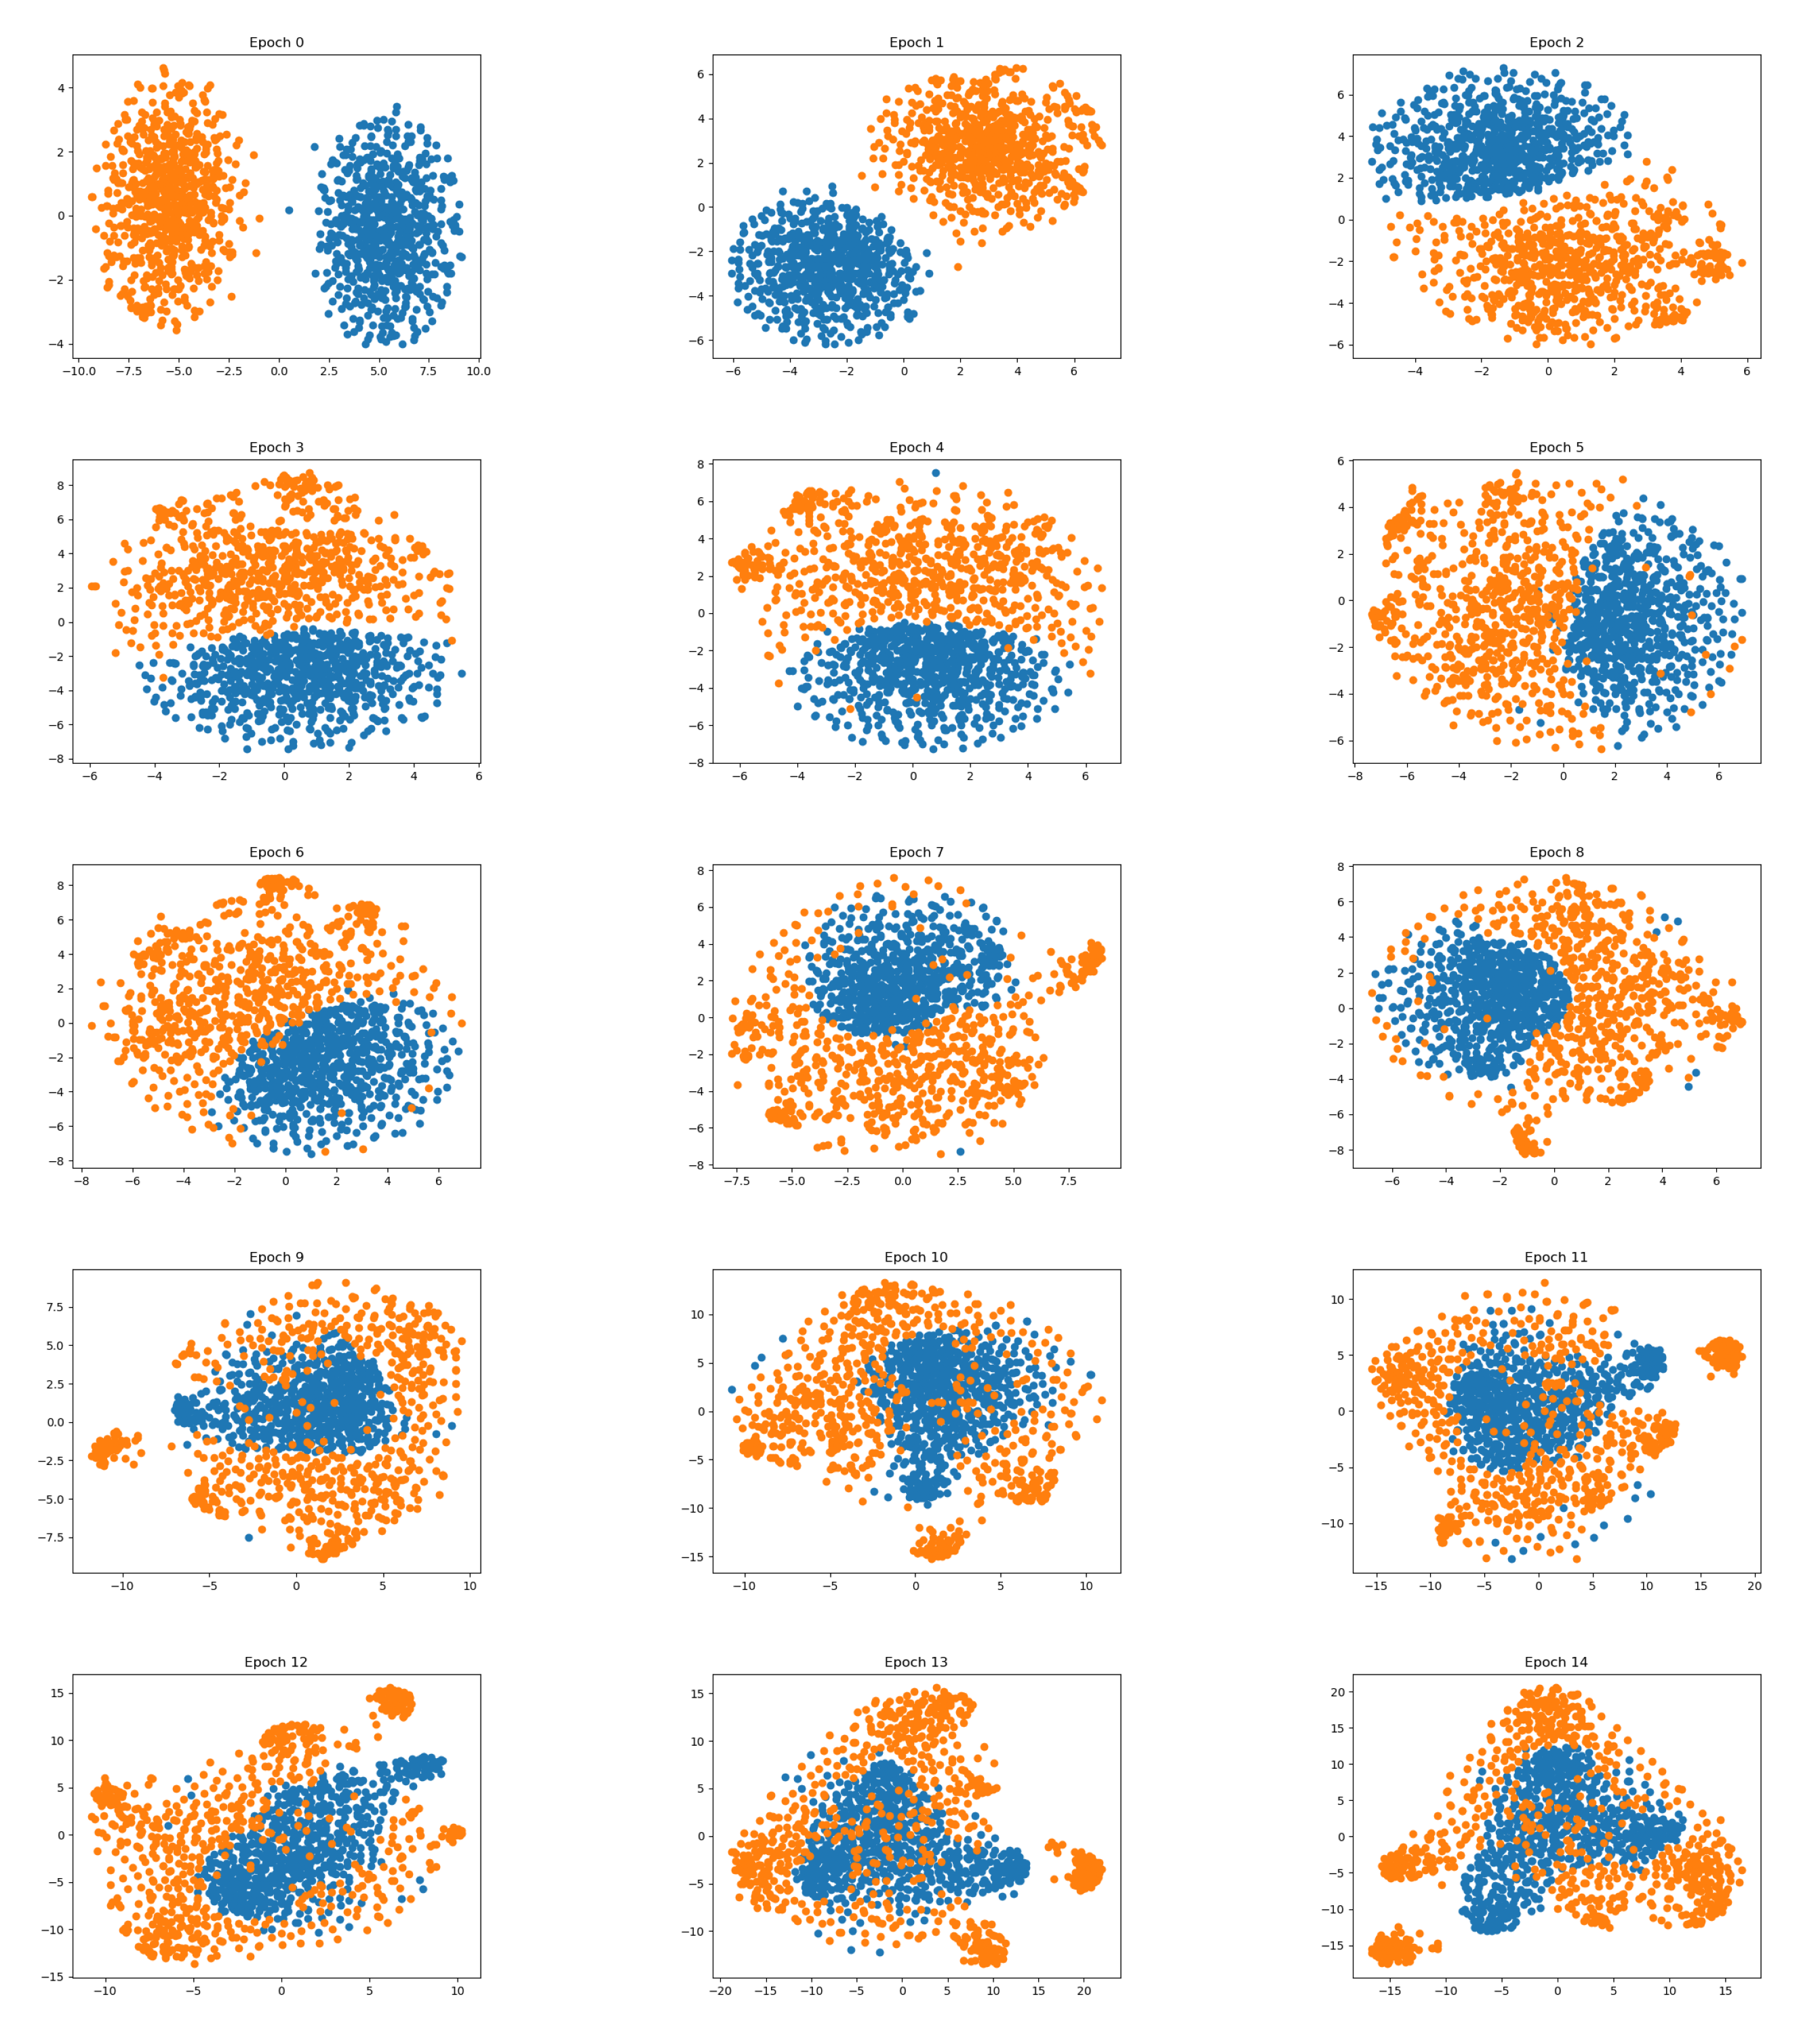

In [123]:
val_type = "train"
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(30, 30))

for i, ax in enumerate(axs.flatten()):
    img = plt.imread(f"saved-figures/latent/{val_type}/latent_{i}.png")
    ax.imshow(img)
    ax.set_axis_off()


plt.tight_layout()
plt.show()

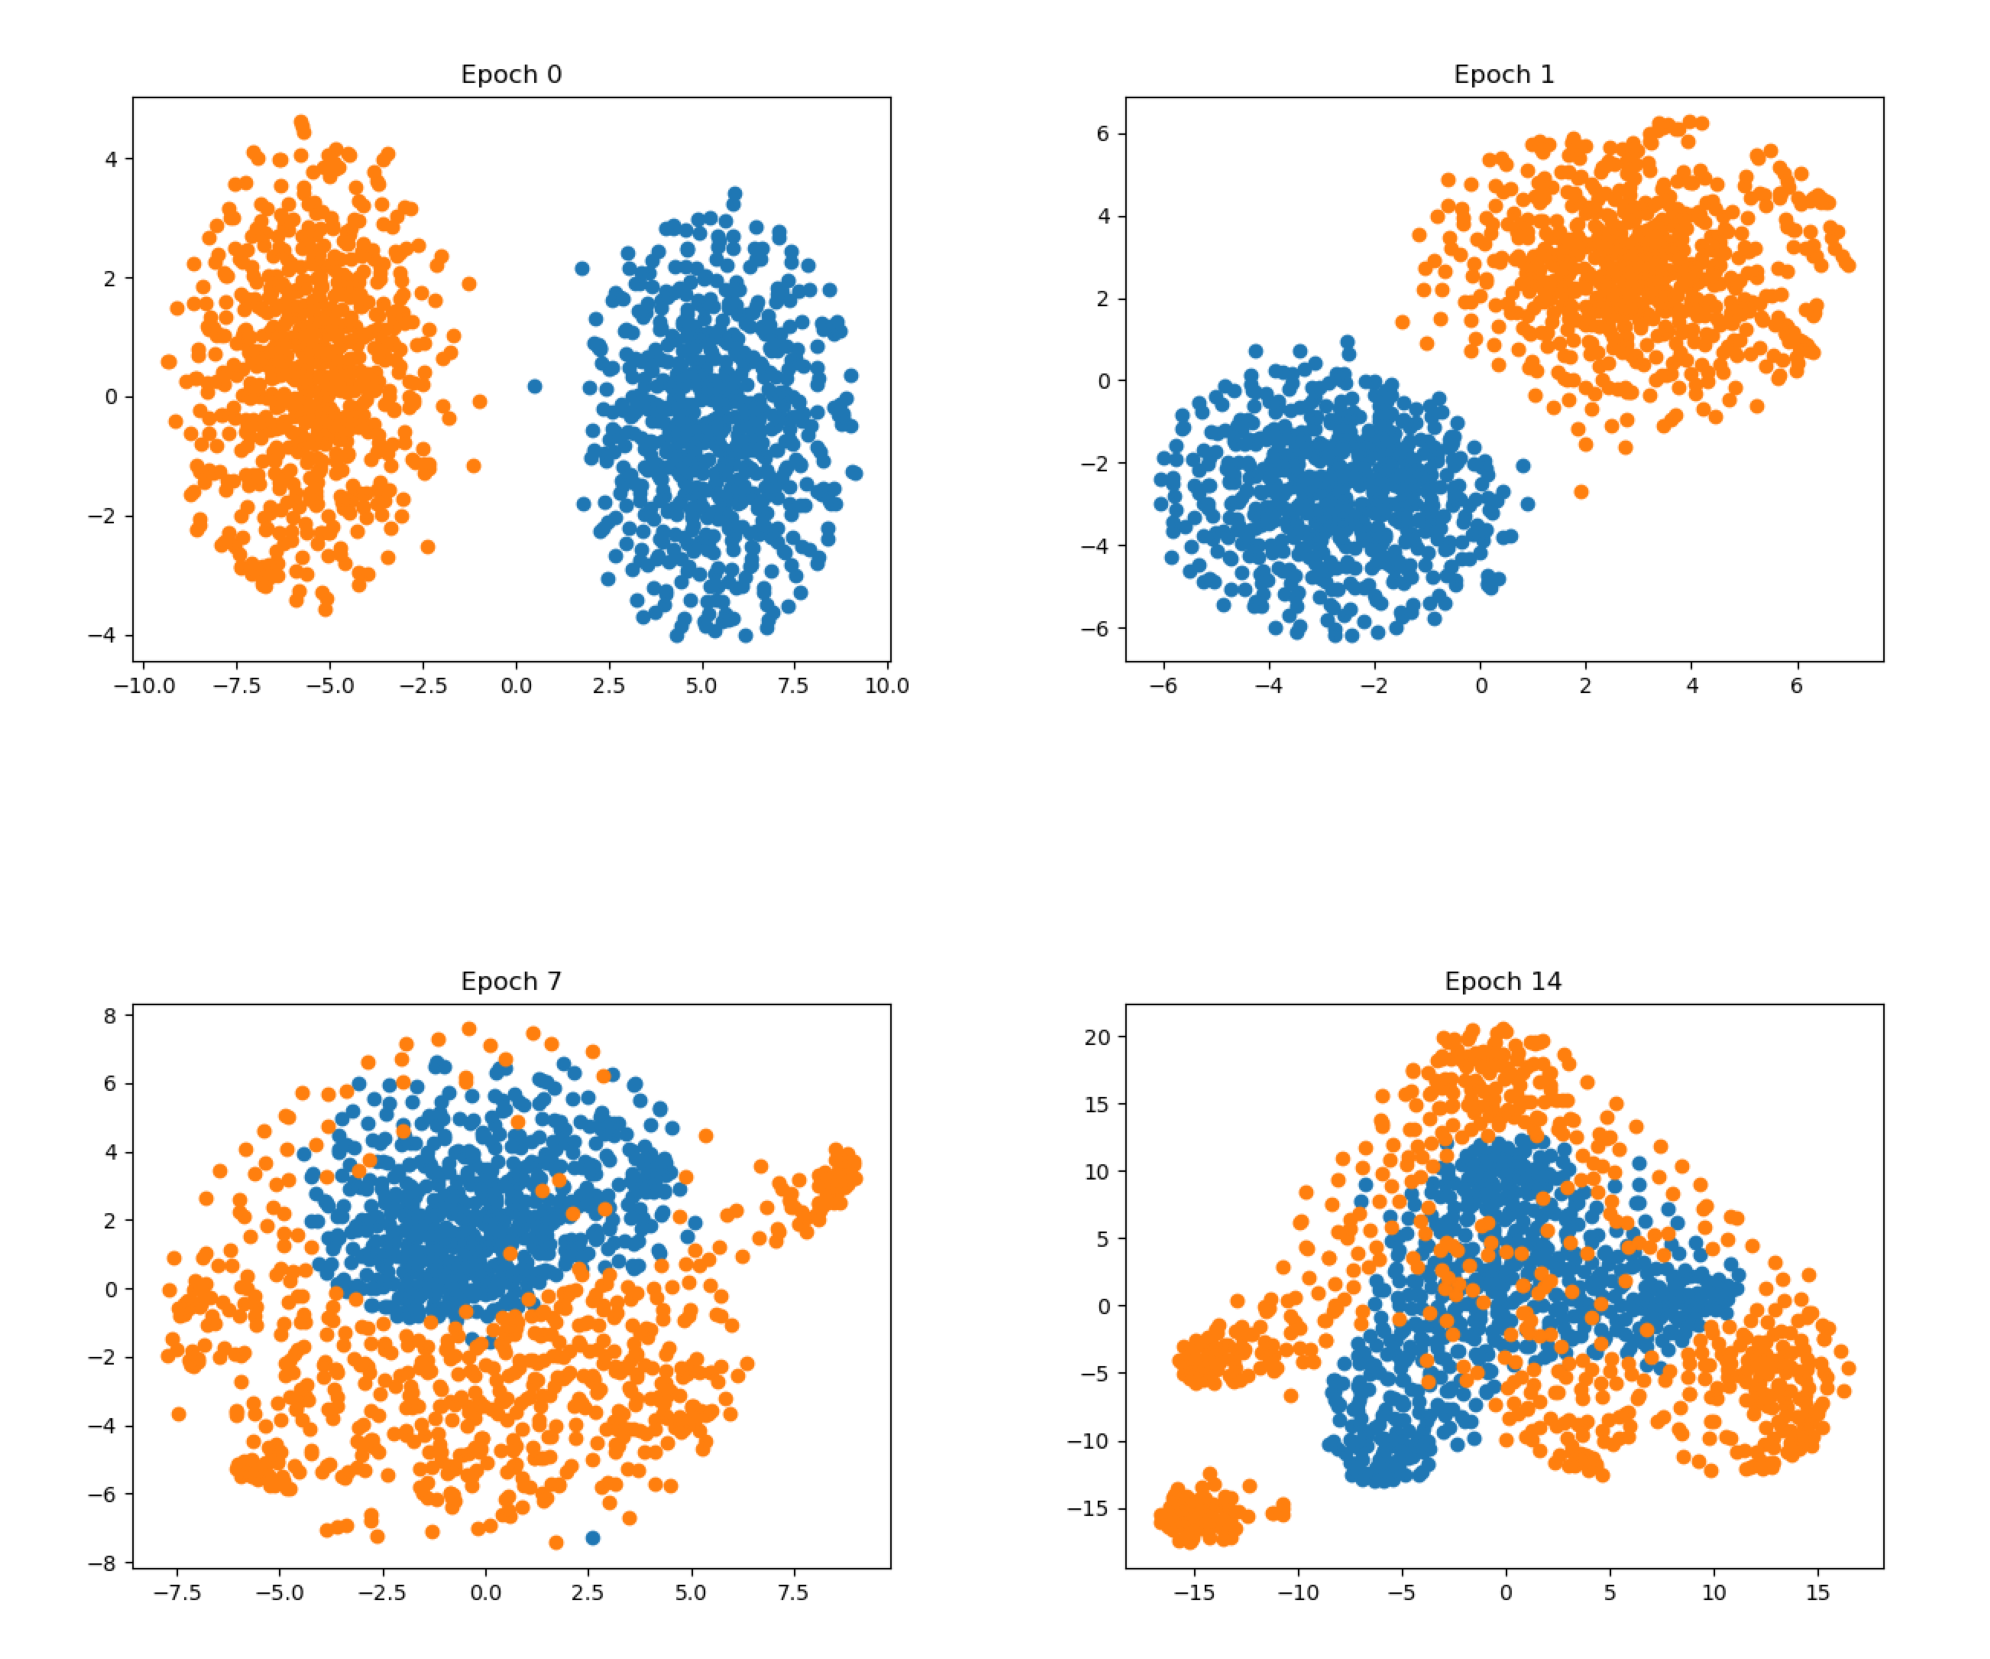

In [124]:
from datetime import datetime

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

for i, ax in zip([0 ,1, 7 , 14], axs.flatten()):
    img = plt.imread(f"saved-figures/latent/train/latent_{i}.png")
    ax.imshow(img)
    ax.set_axis_off()

#Display the figure
plt.tight_layout()
plt.savefig(f"saved-figures/latent/extra/{datetime.now()}.png")
plt.show()